In [1]:
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler

# performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df_fl = pd.read_csv('flights.csv')

In [7]:
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012957 entries, 0 to 6012956
Data columns (total 38 columns):
 #   Column                Dtype  
---  ------                -----  
 0   fl_date               object 
 1   op_carrier            object 
 2   op_carrier_fl_number  int64  
 3   origin                object 
 4   dest                  object 
 5   crs_dep_time          int64  
 6   dep_time              int64  
 7   dep_delay             float64
 8   taxi_out              int64  
 9   wheels_off            int64  
 10  wheels_on             int64  
 11  taxi_in               int64  
 12  crs_arr_time          int64  
 13  arr_time              int64  
 14  arr_delay             float64
 15  canceled              int64  
 16  cancelation_code      float64
 17  diverted              int64  
 18  crs_elapsed_time      int64  
 19  actual_elapsed_time   int64  
 20  air_time              int64  
 21  distance              int64  
 22  carrier_delay         float64
 23  weather

In [7]:
def missing_values_table(df):
    '''
    Small function to print out a missing values table
    
    INPUT:
        dataframe name
        
    OUTPUT:
        missing values table
    '''
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [60]:
missing_values_table(df_fl)

Your selected dataframe has 22 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Imbalanced Data Solution

In [6]:
df_fl.groupby(['delayed']).count()

,fl_date,op_carrier,op_carrier_fl_number,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,dep_hour,dep_min,season,day_part,flight_length,origin_id,dest_id,fl_month,fl_day,op_code
delayed,,,,,,,,,,,,,,,,,,,,,
0,4860160,4860160,4860160,4860160,4860160,4860160,4860160,4855770,4860160,4860160,...,4860160,4860160,4860160,4860160,4860160,4860160,4860160,4860160,4860160,4860160
1,1152797,1152797,1152797,1152797,1152797,1152797,1152797,1152462,1152797,1152797,...,1152797,1152797,1152797,1152797,1152797,1152797,1152797,1152797,1152797,1152797


Not Delayed: 81.0%
Delayed: 19.0%


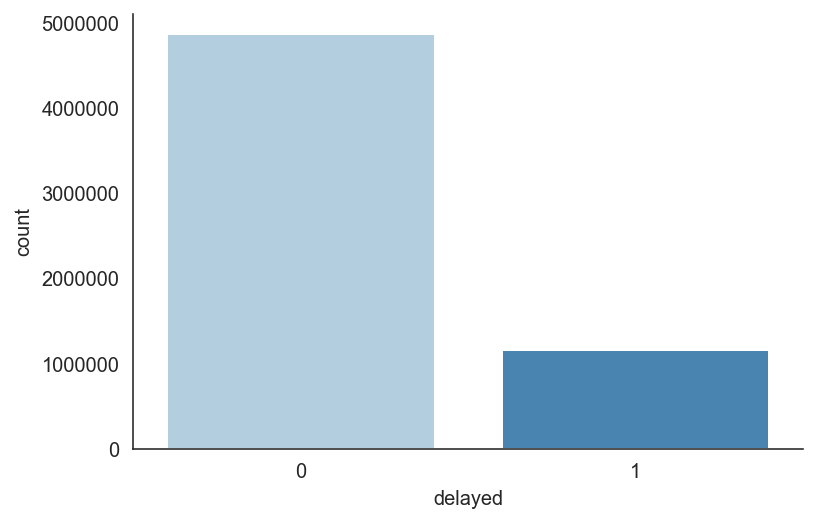

In [44]:
ax = sns.countplot(x="delayed", data=df_fl, palette="Blues")
sns.despine()
sns.set_style('white')
print('Not Delayed: {}%'.format(round((df_fl['delayed'].value_counts()[0] / df_fl.shape[0]), 2)*100))
print('Delayed: {}%'.format(round((df_fl['delayed'].value_counts()[1] / df_fl.shape[0]), 2)*100))
ax.get_figure().savefig("imbalance.png")

In [4]:
#Feature Order
df_fl_last = df_fl[['op_code','op_carrier_fl_number','origin_id','actual_elapsed_time','distance','dest_id','fl_month','fl_day','delayed']]

In [67]:
df_fl_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012957 entries, 0 to 6012956
Data columns (total 9 columns):
 #   Column                Dtype
---  ------                -----
 0   op_code               int64
 1   op_carrier_fl_number  int64
 2   origin_id             int64
 3   actual_elapsed_time   int64
 4   distance              int64
 5   dest_id               int64
 6   fl_month              int64
 7   fl_day                int64
 8   delayed               int64
dtypes: int64(9)
memory usage: 412.9 MB


In [32]:
df_fl_last.corr()

,op_code,op_carrier_fl_number,origin_id,dest_id,actual_elapsed_time,fl_month,fl_day,delayed
op_code,1.000000,0.079977,0.021765,0.021846,-0.024505,-0.012263,-0.000367,0.018603
op_carrier_fl_number,0.079977,1.000000,-0.060387,-0.067627,-0.281606,0.022632,0.011337,0.013994
origin_id,0.021765,-0.060387,1.000000,0.000736,0.088766,-0.000084,-0.000290,-0.003192
dest_id,0.021846,-0.067627,0.000736,1.000000,0.123383,-0.000039,-0.000316,0.011881
actual_elapsed_time,-0.024505,-0.281606,0.088766,0.123383,1.000000,-0.003443,0.000419,0.071018
fl_month,-0.012263,0.022632,-0.000084,-0.000039,-0.003443,1.000000,0.007893,0.006692
fl_day,-0.000367,0.011337,-0.000290,-0.000316,0.000419,0.007893,1.000000,-0.005995
delayed,0.018603,0.013994,-0.003192,0.011881,0.071018,0.006692,-0.005995,1.000000


In [5]:
df_fl_sample=df_fl_last.sample(n=1000000)
df_fl_sample.head()

,op_code,op_carrier_fl_number,origin_id,actual_elapsed_time,distance,dest_id,fl_month,fl_day,delayed
835123,10,4005,142,175,844,138,5,4,0
2025851,8,419,47,124,850,76,5,9,0
914216,10,6111,205,82,395,138,7,15,1
3092854,7,1007,257,162,965,165,4,11,0
5971763,8,1332,245,165,1105,177,4,9,1


In [8]:
missing_values_table(df_fl_sample)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [6]:
df_fl_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 835123 to 5770617
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   op_code               1000000 non-null  int64
 1   op_carrier_fl_number  1000000 non-null  int64
 2   origin_id             1000000 non-null  int64
 3   actual_elapsed_time   1000000 non-null  int64
 4   distance              1000000 non-null  int64
 5   dest_id               1000000 non-null  int64
 6   fl_month              1000000 non-null  int64
 7   fl_day                1000000 non-null  int64
 8   delayed               1000000 non-null  int64
dtypes: int64(9)
memory usage: 76.3 MB


Not Delayed: 81.0%
Delayed: 19.0%


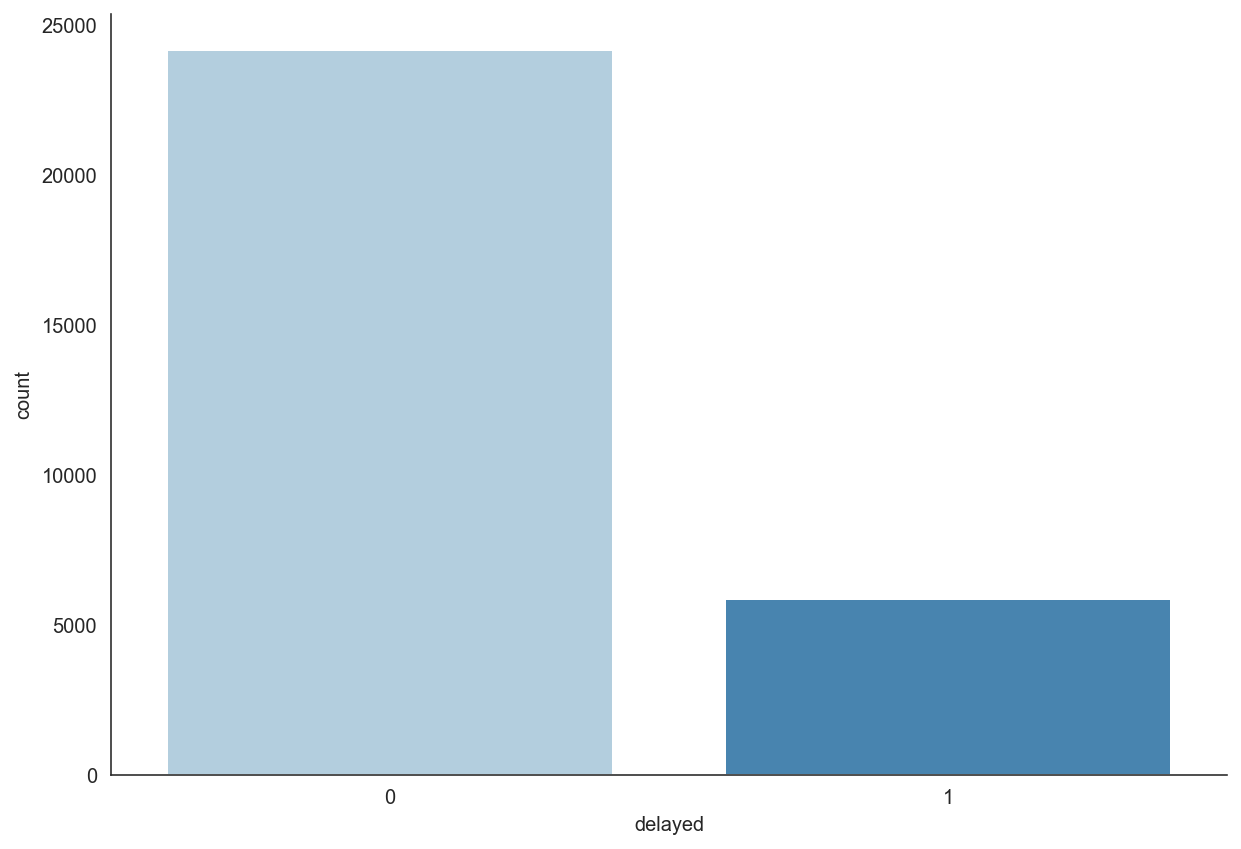

In [70]:
plt.figure(figsize=[10,7])
df_fl_sample.groupby(['delayed']).count()
ax = sns.countplot(x="delayed", data=df_fl_sample, palette="Blues")
sns.despine()
sns.set_style('white')
print('Not Delayed: {}%'.format(round((df_fl_sample['delayed'].value_counts()[0] / df_fl_sample.shape[0]), 2)*100))
print('Delayed: {}%'.format(round((df_fl_sample['delayed'].value_counts()[1] / df_fl_sample.shape[0]), 2)*100))

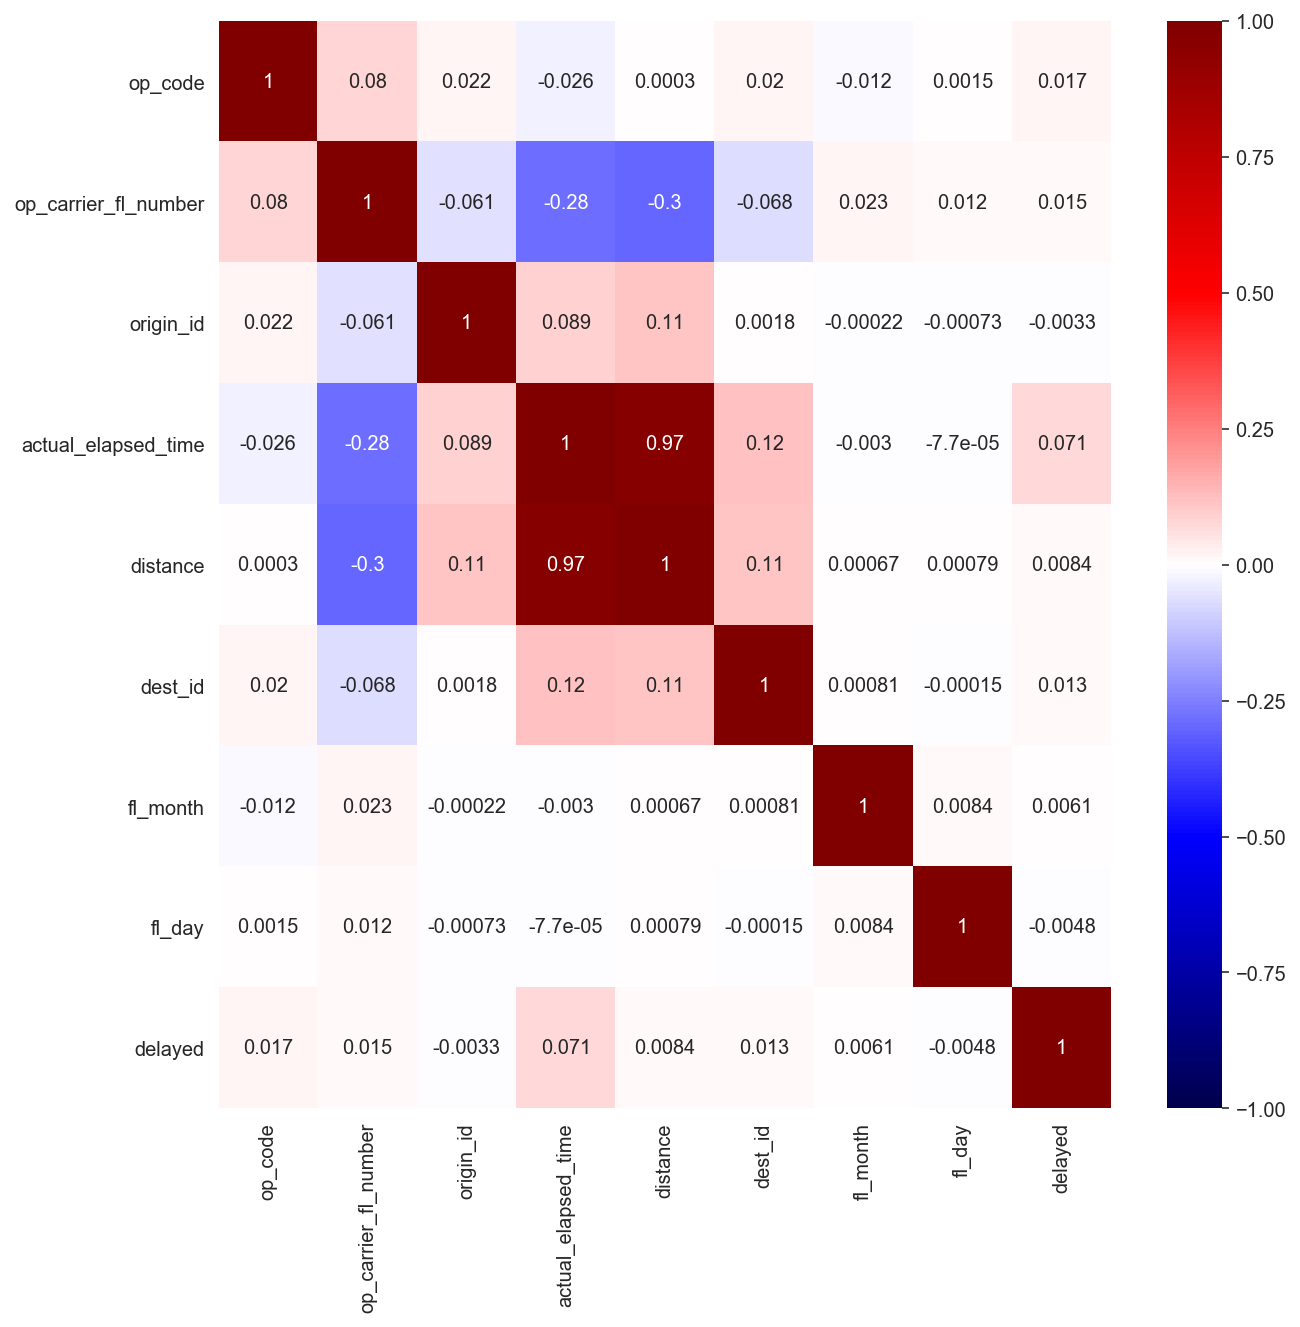

In [50]:
plt.figure(figsize=(10, 10))
sns_heat = sns.heatmap(df_fl_sample.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
sns_heat.get_figure().savefig("heatmap.png")

<Figure size 720x720 with 0 Axes>

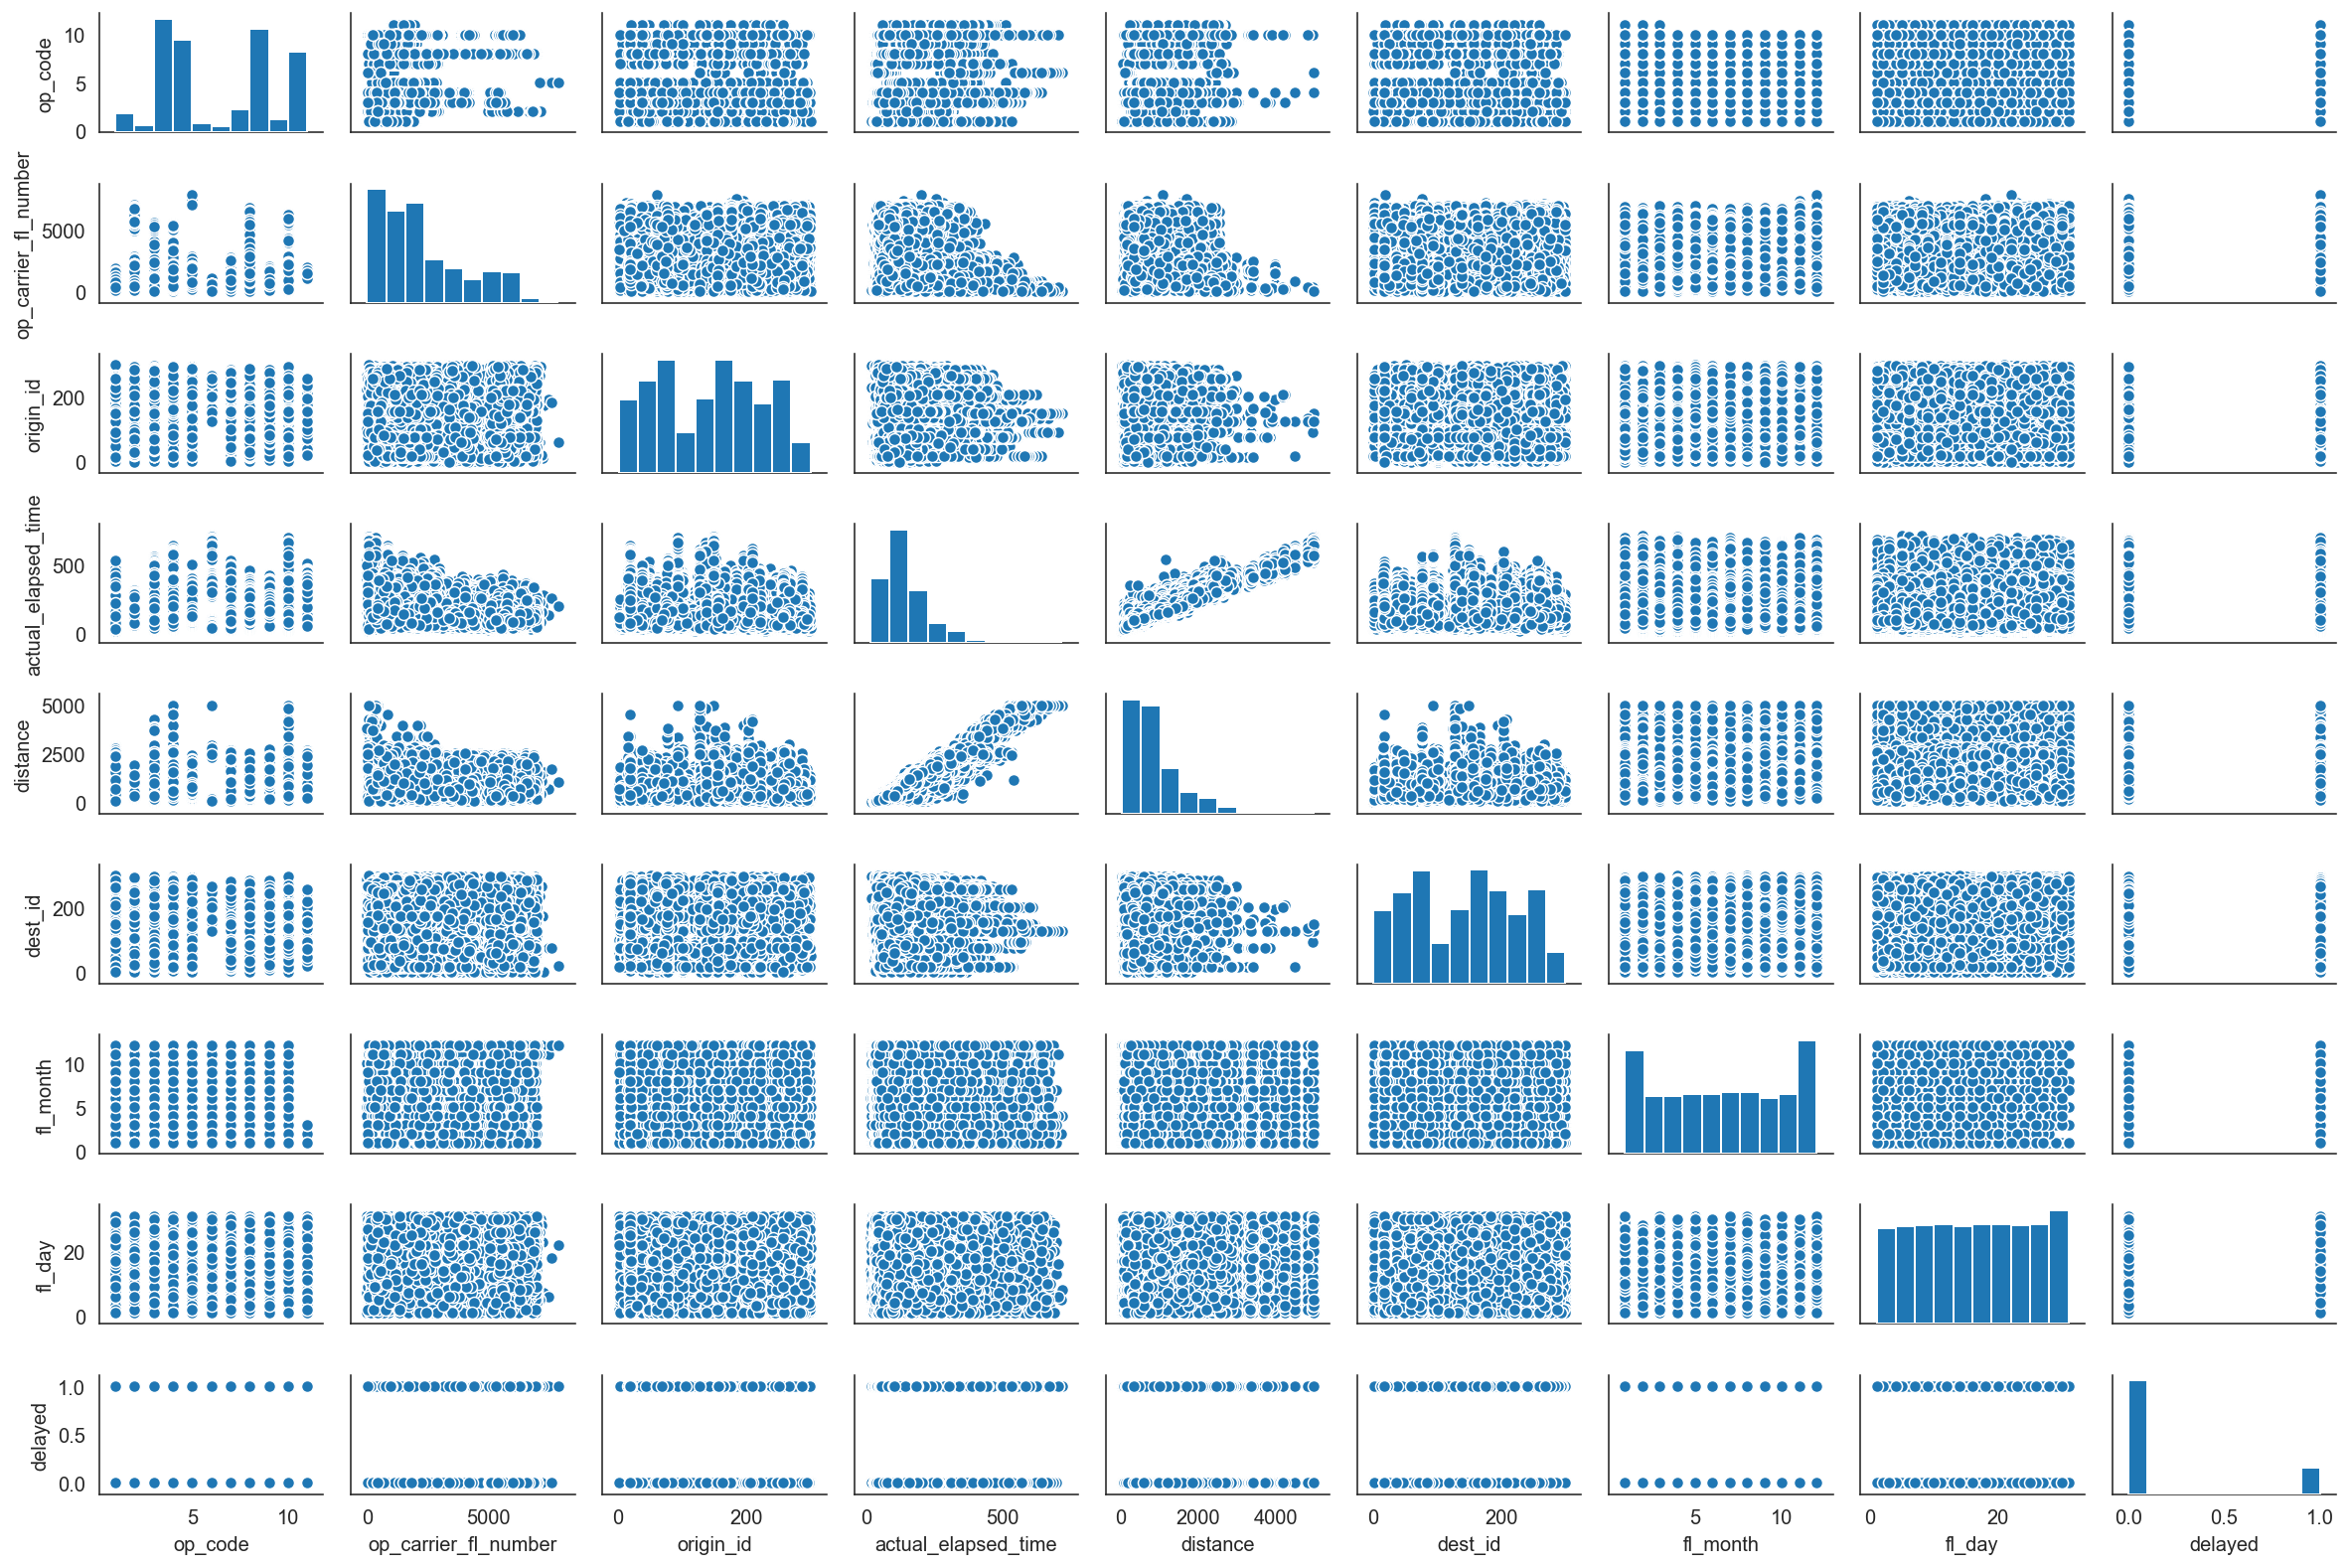

In [51]:
plt.figure(figsize=(10, 10))
sns_pairplot = sns.pairplot(df_fl_sample, height=1.2, aspect=1.5);
sns_pairplot.savefig("pairplot.png")

In [10]:
# Test-train
X = df_fl_sample.iloc[:,:8]
y = df_fl_sample.iloc[:,8]
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=.2, random_state=10)


### RandomUnder sampling

In [12]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 

rd = RandomUnderSampler() 
  
X_train_rd, y_train_rd = rd.fit_sample(X_train, y_train.ravel()) 
X_cv_rd, y_cv_rd = rd.fit_sample(X_cv, y_cv.ravel()) 

  
print('After Undersampling, the shape of X_train: {}'.format(X_train_rd.shape)) 
print('After Undersampling, the shape of y_train: {} \n'.format(y_train_rd.shape)) 

print('After Undersampling, the shape of X_cv: {}'.format(X_cv_rd.shape)) 
print('After Undersampling, the shape of y_cv: {} \n'.format(y_cv_rd.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_rd == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_rd == 0)))

Before Undersampling, counts of label '1': 153274
Before Undersampling, counts of label '0': 646726 

After Undersampling, the shape of X_train: (306548, 8)
After Undersampling, the shape of y_train: (306548,) 

After Undersampling, the shape of X_cv: (77308, 8)
After Undersampling, the shape of y_cv: (77308,) 

After Undersampling, counts of label '1': 153274
After Undersampling, counts of label '0': 153274


### Modelling

In [11]:
#create list of model and accuracy dicts
perform_list = []

# list to keep track of models
models = []

# list to keep track of proba scores
proba_score = []

### 1. Decision Tree Classifier

In [12]:
dt = DecisionTreeClassifier()

# calculate accuracy of train
dt_acc = cross_val_score(dt, X_train_rd, y_train_rd, cv=10).mean()
dt_std = cross_val_score(dt, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Decision Tree (TRAIN): {} +/- {}'.format(round(dt_acc, 2), round(dt_std, 2)))

# fit model
dt.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
dt_pred = dt.predict(X_cv_rd)
dt_proba = dt.predict_proba(X_cv_rd)

# calculate accuracy of test
dt_acc_test = round(accuracy_score(y_cv_rd, dt_pred), 2)
print(f'Accuracy of Decision Tree (TEST): {dt_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, dt_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Decision Tree'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', dt_acc),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Decision Tree')
# add proba socre to list
proba_score.append(dt_proba)


Accuracy of Decision Tree (TRAIN): 0.59 +/- 0.0
Accuracy of Decision Tree (TEST): 0.6
Precision : 0.5951513424428608
Recall    : 0.5951511649286858
F-score   : 0.5951509761072815


### 2. Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=100)


In [14]:
# fit model
rf.fit(X_train_rd, y_train_rd)


RandomForestClassifier()

In [15]:

# calculate accuracy of train
rf_acc = cross_val_score(rf, X_train_rd, y_train_rd, cv=10).mean()
rf_std = cross_val_score(rf, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Random Forest (TRAIN): {} +/- {}'.format(round(rf_acc, 2), round(rf_std, 2)))

# get predictions and probabilities
rf_pred = rf.predict(X_cv_rd)
rf_proba= rf.predict_proba(X_cv_rd)

# calculate accuracy of test
rf_acc_test = round(accuracy_score(y_cv_rd, rf_pred), 2)
print(f'Accuracy of Random Forest (TEST): {rf_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, rf_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', rf_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Random Forest')

# add proba socre to list
proba_score.append(rf_proba)

Accuracy of Random Forest (TRAIN): 0.66 +/- 0.0
Accuracy of Random Forest (TEST): 0.66
Precision : 0.6616117730111648
Recall    : 0.6607916787055764
F-score   : 0.6603608063695745


### 3. Bagging

In [16]:
from sklearn import model_selection

bagg = BaggingClassifier(n_estimators=30)

# calculate accuracy of train
kfold = model_selection.KFold(n_splits=10, random_state=7)
bagg_acc = model_selection.cross_val_score(bagg , X_train_rd, y_train_rd, cv=kfold).mean()
bagg_std = model_selection.cross_val_score(bagg , X_train_rd, y_train_rd, cv=kfold).std()
print('Accuracy of Extra Trees Classifier (TRAIN): {} +/- {}'.format(round(bagg_acc, 2), round(bagg_std, 2)))

# fit model
bagg.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
bagg_pred = rf.predict(X_cv_rd)
bagg_proba= rf.predict_proba(X_cv_rd)

# calculate accuracy of test
bagg_acc_test = round(accuracy_score(y_cv_rd, bagg_pred), 2)
print(f'Accuracy of Bagging Classifier (TEST): {bagg_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, bagg_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Bagging'),
    ('Train Accuracy', round(bagg_acc, 2)),
    ('Test Accuracy', bagg_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Bagging')

# add proba socre to list
proba_score.append(bagg_proba)

Accuracy of Extra Trees Classifier (TRAIN): 0.57 +/- 0.05
Accuracy of Bagging Classifier (TEST): 0.66
Precision : 0.6616117730111648
Recall    : 0.6607916787055764
F-score   : 0.6603608063695745


### 4. KNN

In [17]:
test_scores = []
k_list = []

for i in range(1,21):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_rd,y_train_rd)
    y_pred = knn.predict(X_cv_rd)
    
    test_scores.append(accuracy_score(y_cv_rd,y_pred))
    k_list.append(i)
    
print(test_scores)

[0.6016390428410076, 0.5948884978067295, 0.607286385963069, 0.6023876441385831, 0.6072732526069712, 0.6011925087336818, 0.6061306506264611, 0.6002075070263455, 0.604055580363006, 0.5999185731921935, 0.6029917785190828, 0.5983163037482598, 0.5996427727141393, 0.5963857004018807, 0.5979748364897166, 0.5940085629481757, 0.5948490977384361, 0.5935751621969478, 0.5928922276798613, 0.5921042263139923]


In [18]:
max_test_score = max(test_scores)

best_k=k_list[test_scores.index(max_test_score)] 

print("Maximum K value:", best_k, "\nMaximum test score:", max_test_score)

Maximum K value: 3 
Maximum test score: 0.607286385963069


In [19]:
knn = KNeighborsClassifier(n_neighbors=16)
knn_acc = cross_val_score(knn, X_train_rd, y_train_rd, cv=10).mean()
knn_std = cross_val_score(knn, X_train_rd, y_train_rd, cv=10).std()

# calculate accuracy of train
print('Accuracy of KNN (TRAIN): {} +/- {}'.format(round(knn_acc, 2), round(knn_std, 2)))

# fit the model
knn.fit(X_train_rd,y_train_rd)

# get predictions and probabilities
knn_pred = knn.predict(X_cv_rd)
knn_proba = knn.predict_proba(X_cv_rd)

# calculate accuracy of test
knn_acc_cv = round(accuracy_score(y_cv_rd, knn_pred), 2)
print(f'Accuracy of KNN (TEST): {knn_acc_cv}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, knn_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', knn_acc_cv),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('KNN')
# add proba socre to list
proba_score.append(knn_proba)

Accuracy of KNN (TRAIN): 0.59 +/- 0.0
Accuracy of KNN (TEST): 0.59
Precision : 0.599298305314748
Recall    : 0.5940085629481758
F-score   : 0.5885286674618995


### 5. Logistic regression

In [20]:
lr = LogisticRegression(random_state=1)

# calculate accuracy of train
lr_acc = cross_val_score(lr, X_train_rd, y_train_rd, cv=10).mean()
lr_std = cross_val_score(lr, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Logistic Regression (TRAIN): {} +/- {}'.format(round(lr_acc, 2), round(lr_std, 2)))

# fit model
lr.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
lr_pred = lr.predict(X_cv_rd)
lr_proba = lr.predict_proba(X_cv_rd)

# calculate accuracy of test
lr_acc_test = round(accuracy_score(y_cv_rd, lr_pred), 2)
print(f'Accuracy of Logistic Regression (TEST): {lr_acc_test}')

print()

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, lr_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', lr_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Logistic Regression')

# add proba score to list
proba_score.append(lr_proba)

Accuracy of Logistic Regression (TRAIN): 0.58 +/- 0.0
Accuracy of Logistic Regression (TEST): 0.58

Precision : 0.5806382735737192
Recall    : 0.5805731396601087
F-score   : 0.5804884266901891


### 6. Navie bayes

In [21]:
nb = GaussianNB()

# calculate accuracy of train
nb_acc = cross_val_score(nb, X_train_rd, y_train_rd, cv=10).mean()
nb_std = cross_val_score(nb, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Naive Bayes Classifier (TRAIN): {} +/- {}'.format(round(nb_acc, 2), round(nb_std, 2)))

# cit model
nb.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
nb_pred = nb.predict(X_cv_rd)
nb_proba = nb.predict_proba(X_cv_rd)

# calculate accuracy of test
nb_acc_test = round(accuracy_score(y_cv_rd, nb_pred), 2)
print(f'Accuracy of Naive Bayes Classifier (TEST): {nb_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, nb_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(nb_acc, 2)),
    ('Test Accuracy', nb_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Naive Bayes')

# add proba score to list
proba_score.append(nb_proba)

Accuracy of Naive Bayes Classifier (TRAIN): 0.54 +/- 0.0
Accuracy of Naive Bayes Classifier (TEST): 0.54
Precision : 0.5418298327784561
Recall    : 0.5395051351422342
F-score   : 0.5330169767017814


### 7. Ekstra tree

In [22]:
from sklearn import model_selection

etc = ExtraTreesClassifier(n_estimators=100)

# calculate accuracy of train
kfold = model_selection.KFold(n_splits=10, random_state=7)
etc_acc = model_selection.cross_val_score(etc, X_train_rd, y_train_rd, cv=kfold).mean()
etc_std = model_selection.cross_val_score(etc, X_train_rd, y_train_rd, cv=kfold).std()
print('Accuracy of Extra Trees Classifier (TRAIN): {} +/- {}'.format(round(etc_acc, 2), round(etc_std, 2)))

# fit model
etc.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
etc_pred = rf.predict(X_cv_rd)
etc_proba= rf.predict_proba(X_cv_rd)

# calculate accuracy of test
etc_acc_test = round(accuracy_score(y_cv_rd, etc_pred), 2)
print(f'Accuracy of Extra Trees Classifier (TEST): {etc_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, etc_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Extra Trees'),
    ('Train Accuracy', round(etc_acc, 2)),
    ('Test Accuracy', etc_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Extra Trees')

# add proba socre to list
proba_score.append(etc_proba)

Accuracy of Extra Trees Classifier (TRAIN): 0.55 +/- 0.02
Accuracy of Extra Trees Classifier (TEST): 0.66
Precision : 0.6616117730111648
Recall    : 0.6607916787055764
F-score   : 0.6603608063695745


### 8. ADA Boost

In [23]:
abc = AdaBoostClassifier(n_estimators=30, random_state=7)


# calculate accuracy of train
kfold = model_selection.KFold(n_splits=10, random_state=7)
abc_acc = model_selection.cross_val_score(abc, X_train_rd, y_train_rd, cv=kfold).mean()
abc_std = model_selection.cross_val_score(abc, X_train_rd, y_train_rd, cv=kfold).std()
print('Accuracy of Ada Boost Classifier (TRAIN): {} +/- {}'.format(round(abc_acc, 2), round(abc_std, 2)))

# fit model
abc.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
abc_pred = abc.predict(X_cv_rd)
abc_proba= abc.predict_proba(X_cv_rd)

# calculate accuracy of test
abc_acc_test = round(accuracy_score(y_cv_rd, abc_pred), 2)
print(f'Accuracy of Ada Boost Classifier (TEST): {abc_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, abc_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Ada Boost'),
    ('Train Accuracy', round(abc_acc, 2)),
    ('Test Accuracy', abc_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Ada Boost')

# add proba socre to list
proba_score.append(abc_proba)

Accuracy of Ada Boost Classifier (TRAIN): 0.33 +/- 0.02
Accuracy of Ada Boost Classifier (TEST): 0.6
Precision : 0.6030337655813881
Recall    : 0.6025583777678548
F-score   : 0.6020994090723564


### 9. Stochastic Gradient Boost

In [24]:
sgb = GradientBoostingClassifier(n_estimators=30, random_state=7)

# calculate accuracy of train
kfold = model_selection.KFold(n_splits=10, random_state=7)
sgb_acc = model_selection.cross_val_score(sgb, X_train_rd, y_train_rd, cv=kfold).mean()
sgb_std = model_selection.cross_val_score(sgb, X_train_rd, y_train_rd, cv=kfold).std()
print('Accuracy of Stochastic Gradient Boost (TRAIN): {} +/- {}'.format(round(sgb_acc, 2), round(sgb_std, 2)))

# fit model
sgb.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
sgb_pred = sgb.predict(X_cv_rd)
sgb_proba= sgb.predict_proba(X_cv_rd)

# calculate accuracy of test
sgb_acc_test = round(accuracy_score(y_cv_rd, sgb_pred), 2)
print(f'Accuracy of Stochastic Gradient Boost (TEST): {sgb_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, sgb_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Stochastic Gradient Boost'),
    ('Train Accuracy', round(sgb_acc, 2)),
    ('Test Accuracy', sgb_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Stochastic Gradient Boost')

# add proba socre to list
proba_score.append(sgb_proba)

Accuracy of Stochastic Gradient Boost (TRAIN): 0.26 +/- 0.01
Accuracy of Stochastic Gradient Boost (TEST): 0.62
Precision : 0.6212885224100486
Recall    : 0.6171364030364319
F-score   : 0.6138314366190929


### 10. XGB Classifier

In [28]:
import xgboost as xgb
from xgboost import XGBClassifier

In [29]:
xgb = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

# calculate accuracy of train
xgb_acc = cross_val_score(xgb, X_train_rd, y_train_rd, cv=10).mean()
xgb_std = cross_val_score(xgb, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of XGBoost (TRAIN): {} +/- {}'.format(round(xgb_acc, 2), round(xgb_std, 2)))

# fit model
xgb.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
xgb_pred = xgb.predict(X_cv_rd)
xgb_proba= xgb.predict_proba(X_cv_rd)

# calculate accuracy of test
xgb_acc_test = round(accuracy_score(y_cv_rd, xgb_pred), 2)
print(f'Accuracy of XGBoost (TEST): {xgb_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, xgb_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'XGBoost'),
    ('Train Accuracy', round(xgb_acc, 2)),
    ('Test Accuracy', xgb_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('XGBoost')

# add proba socre to list
proba_score.append(xgb_proba)

Accuracy of XGBoost (TRAIN): 0.58 +/- 0.0
Accuracy of XGBoost (TEST): 0.59
Precision : 0.586488221868577
Recall    : 0.5858133487431378
F-score   : 0.5850037882491805


## Optimization

### 1. RandomForest GridCV

In [30]:
# search the best parameter
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5], "min_samples_split" : [2, 4], "n_estimators": [100, 400]}
rf_cv = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf_cv, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train_rd, y_train_rd)
clf.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 400}

In [14]:
# apply best parameter to model
rf_grid = RandomForestClassifier(n_estimators=400,
                                criterion='gini',
                                min_samples_split=2,
                                min_samples_leaf=5,)

# calculate the accuracy of train
rf_grid_acc = cross_val_score(rf_grid, X_train_rd, y_train_rd).mean()
rf_grid_std = cross_val_score(rf_grid, X_train_rd, y_train_rd).std()
print('Accuracy of Random Forest GS (TRAIN): {} +/- {}'.format(round(rf_grid_acc, 2), round(rf_grid_std, 2)))

# fit model
rf_grid.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
rf_grid_pred = rf_grid.predict(X_cv_rd)
rf_grid_proba = rf_grid.predict_proba(X_cv_rd)

# calculate accuracy of test
rf_grid_acc_test = round(accuracy_score(y_cv_rd, rf_grid_pred), 2)
print(f'Accuracy of Random Forest GS (TEST): {rf_grid_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, rf_grid_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Random Forest GS'),
    ('Train Accuracy', round(rf_grid_acc, 2)),
    ('Test Accuracy', rf_grid_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Random Forest GS')

# add proba socre to list
proba_score.append(rf_grid_proba)

Accuracy of Random Forest GS (TRAIN): 0.67 +/- 0.0
Accuracy of Random Forest GS (TEST): 0.67
Precision : 0.673248295625297
Recall    : 0.6717804108242356
F-score   : 0.671083706671887


NameError: name 'perform_list' is not defined

### 2. Random Forest RandomizedSearchCV¶

In [32]:
# search the best parameter
n_estimators_range = [x for x in range(1,31)]
criterion_range = ['gini', 'entropy']
max_features_range = [None, 'auto', 'log2', 1, 2, 3]
max_depth_range = [None, 1, 2, 3]
min_samples_split_range = [10, 20, 50]
min_samples_leaf_range = [10, 20, 50]
bootstrap_range = [True, False]

param_random = dict(n_estimators=n_estimators_range,
                     criterion=criterion_range,
                     max_features=max_features_range,
                     max_depth=max_depth_range,
                     min_samples_split=min_samples_split_range,
                     min_samples_leaf=min_samples_leaf_range,
                     bootstrap=bootstrap_range
)

# choose number of searches
n_iter_search = 40

rf_random = RandomizedSearchCV(rf, param_distributions=param_random, n_iter=n_iter_search)

# fit the model
rf_random.fit(X_train_rd, y_train_rd)

rf_random.best_params_

{'n_estimators': 21,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 1,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': True}

In [33]:
 # apply best parameter to model 
rf_random = RandomForestClassifier(n_estimators=21,
                                criterion='entropy',
                                max_features=1,
                                max_depth=None,
                                min_samples_split=20,
                                min_samples_leaf=10,
                                bootstrap=True,
                                random_state=1)

# calculate the accuracy of train
rf_random_acc = cross_val_score(rf_random, X_train_rd, y_train_rd).mean()
rf_randomt_std = cross_val_score(rf_random, X_train_rd, y_train_rd).std()
print('Accuracy of Random Forest RS (TRAIN): {} +/- {}'.format(round(rf_random_acc, 2), round(rf_randomt_std, 2)))

# fit model
rf_random.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
rf_random_pred = rf_random.predict(X_cv_rd)
rf_random_proba = rf_random.predict_proba(X_cv_rd)

# calculate accuracy of test
rf_random_acc_test = round(accuracy_score(y_cv_rd, rf_random_pred), 2)
print(f'Accuracy of Random Forest RS (TEST): {rf_random_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, rf_random_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Random Forest RS'),
    ('Train Accuracy', round(rf_random_acc, 2)),
    ('Test Accuracy', rf_random_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Random Forest RS')

# add proba socre to list
proba_score.append(rf_random_proba)

Accuracy of Random Forest RS (TRAIN): 0.65 +/- 0.0
Accuracy of Random Forest RS (TEST): 0.65
Precision : 0.6528715714417762
Recall    : 0.6526227312127342
F-score   : 0.6524813108207734


### 3. Decision Tree GridSearchCV

In [34]:
# find the best parameter
criterion_range = ['gini', 'entropy']
splitter_range = ['best', 'random']
max_depth_range = [None, 1, 2, 3]
min_samples_split_range = [10, 20]
min_samples_leaf_range = [10, 20]

param_grid2 = dict(criterion=criterion_range,
                    splitter=splitter_range,
                    max_depth=max_depth_range,
                    min_samples_split=min_samples_split_range,
                    min_samples_leaf=min_samples_leaf_range
)

dt_cv = GridSearchCV(dt, param_grid2)

# fit the model
dt_cv.fit(X_train_rd, y_train_rd)

dt_cv.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'splitter': 'best'}

In [35]:
# apply best parameter to model
dt_grid = DecisionTreeClassifier(criterion='gini',
                                 splitter='best',
                                 max_depth=None,
                                 min_samples_split=20,
                                 min_samples_leaf=20,
                                 random_state=1)

# calculate accuracy
dt_grid_acc = cross_val_score(dt_grid, X_train_rd, y_train_rd).mean()
dt_grid_std = cross_val_score(dt_grid, X_train_rd, y_train_rd).std()
print('Accuracy of Decision Tree GridSearchCV (TEST): {} +/- {}'.format(round(dt_grid_acc, 2), round(dt_grid_std, 2)))

# fit model
dt_grid.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
dt_grid_pred = dt_grid.predict(X_cv_rd)
dt_grid_proba = dt_grid.predict_proba(X_cv_rd)

# calculate accuracy of test
dt_grid_acc_test = round(accuracy_score(y_cv_rd, dt_grid_pred), 2)
print(f'Accuracy of Decision Tree GridSearchCV (TEST): {dt_grid_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_rd, dt_grid_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Decision Tree GS'),
    ('Train Accuracy', round(dt_grid_acc, 2)),
    ('Test Accuracy', dt_grid_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Decision Tree GS')

# add proba socre to list
proba_score.append(dt_grid_proba)

Accuracy of Decision Tree GridSearchCV (TEST): 0.62 +/- 0.0
Accuracy of Decision Tree GridSearchCV (TEST): 0.62
Precision : 0.6203547719732516
Recall    : 0.6197368075437997
F-score   : 0.6192480625819017


### Model Performans

In [36]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,Decision Tree,0.59,0.593363,0.60,0.60,0.60
1,Random Forest,0.66,0.660000,0.66,0.66,0.66
2,Bagging,0.57,0.660000,0.66,0.66,0.66
3,KNN,0.59,0.590000,0.60,0.59,0.59
4,Logistic Regression,0.58,0.580000,0.58,0.58,0.58
5,Naive Bayes,0.54,0.540000,0.54,0.54,0.53
6,Extra Trees,0.55,0.660000,0.66,0.66,0.66
7,Ada Boost,0.33,0.600000,0.60,0.60,0.60
8,Stochastic Gradient Boost,0.26,0.620000,0.62,0.62,0.61
9,XGBoost,0.58,0.590000,0.59,0.59,0.59


In [37]:
def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2
    
    # Decision Tree
    fpr, tpr, thresholds = roc_curve(y_cv_rd, dt_proba[:,1], pos_label=1)
    auc_dt = roc_auc_score(y_cv_rd, dt_proba[:,1])
    plt.plot(fpr, tpr, color='m',
             lw=lw, label='Decision Tree, auc=%.3f' % auc_dt)
   
    # Random Forest 
    fpr, tpr, thresholds = roc_curve(y_cv_rd, rf_proba[:,1], pos_label=1)
    auc_rf = roc_auc_score(y_cv_rd, rf_proba[:,1])
    plt.plot(fpr, tpr, color='g',
             lw=lw, label='Random Forest, auc=%.3f' % auc_rf)
     
    #Bagging
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_cv_rd, lr_proba[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_cv_rd, bagg_proba[:,1])
    plt.plot(fpr, tpr, color='orange',
             lw=lw, label='Bagging, auc=%.3f' % auc_lr)
         
    # KNN
    fpr, tpr, thresholds = roc_curve(y_cv_rd, knn_proba[:,1], pos_label=1)
    auc_knn = roc_auc_score(y_cv_rd, knn_proba[:,1])
    plt.plot(fpr, tpr, color='y',
             lw=lw, label='KNN, auc=%.3f' % auc_knn)
    
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_cv_rd, lr_proba[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_cv_rd, lr_proba[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR, auc=%.3f' % auc_lr)
           
    # Naive Bayes
    fpr, tpr, thresholds = roc_curve(y_cv_rd, nb_proba[:,1], pos_label=1)
    auc_nbc = roc_auc_score(y_cv_rd, nb_proba[:,1])
    plt.plot(fpr, tpr, color='chartreuse',
             lw=lw, label='Naive Bayes, auc=%.3f' % auc_nbc)
    
    # Extra Trees
    fpr, tpr, thresholds = roc_curve(y_cv_rd, etc_proba[:,1], pos_label=1)
    auc_etc = roc_auc_score(y_cv_rd, etc_proba[:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Extra Trees, auc=%.3f' % auc_etc)
    
    # Ada Boost Classifier
    fpr, tpr, thresholds = roc_curve(y_cv_rd, abc_proba[:,1], pos_label=1)
    auc_abc = roc_auc_score(y_cv_rd, abc_proba[:,1])
    plt.plot(fpr, tpr, color='#00cc99',
             lw=lw, label='Ada Boost, auc=%.3f' % auc_abc)
    
    # Stochastic Gradient Boost Classifier
    fpr, tpr, thresholds = roc_curve(y_cv_rd, sgb_proba[:,1], pos_label=1)
    auc_sgb = roc_auc_score(y_cv_rd, sgb_proba[:,1])
    plt.plot(fpr, tpr, color='#08e8de',
             lw=lw, label='Stochastic Gradient Boost, auc=%.3f' % auc_sgb)
    
    # XGBoost Classifier
    fpr, tpr, thresholds = roc_curve(y_cv_rd, xgb_proba[:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_cv_rd, xgb_proba[:,1])
    plt.plot(fpr, tpr, color='#f4bbff',
             lw=lw, label='XGBoost, auc=%.3f' % auc_xgb)    
    
    # RF GS 
    fpr, tpr, thresholds = roc_curve(y_cv_rd, rf_grid_proba[:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_cv_rd, rf_grid_proba[:,1])
    plt.plot(fpr, tpr, color='Black',
             lw=lw, label='RF GS, auc=%.3f' % auc_xgb)   
    
    # Rf Rs
    fpr, tpr, thresholds = roc_curve(y_cv_rd, rf_random_proba[:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_cv_rd, rf_random_proba[:,1])
    plt.plot(fpr, tpr, color='#FF3393',
             lw=lw, label='RF RS, auc=%.3f' % auc_xgb)   
    
    # Ds GS 
    fpr, tpr, thresholds = roc_curve(y_cv_rd, dt_grid_proba[:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_cv_rd, dt_grid_proba[:,1])
    plt.plot(fpr, tpr, color='#3349FF',
             lw=lw, label='DS GS, auc=%.3f' % auc_xgb)   
    
    # Formatting
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()


<Figure size 1224x720 with 0 Axes>

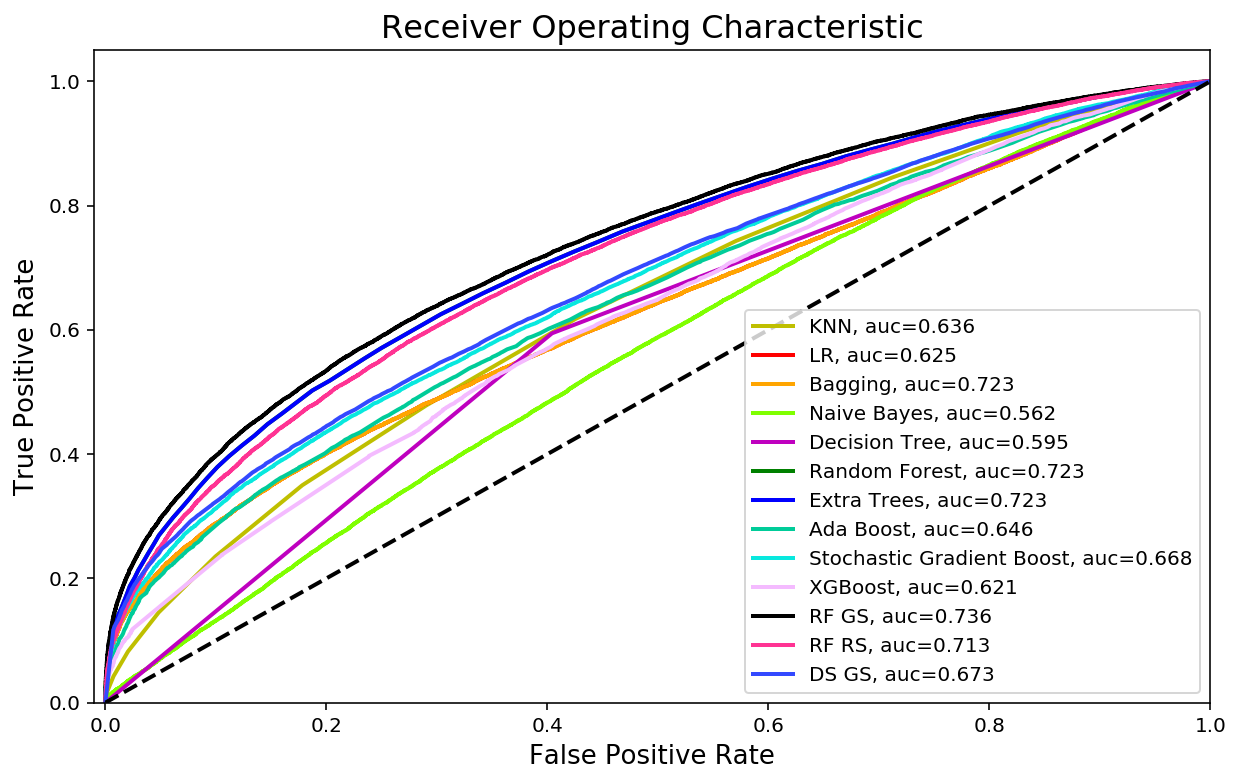

<Figure size 432x288 with 0 Axes>

In [38]:
plt.figure(figsize=[17,10])
plot_roc_curves()
plt.savefig('roc.jpeg')

In [15]:
rf_cmatrix=confusion_matrix(y_cv_rd, rf_grid.predict(X_cv_rd))
print("Random Forest GS confusion matrix: \n\n", rf_cmatrix)


Random Forest GS confusion matrix: 

 [[27746 10908]
 [14466 24188]]


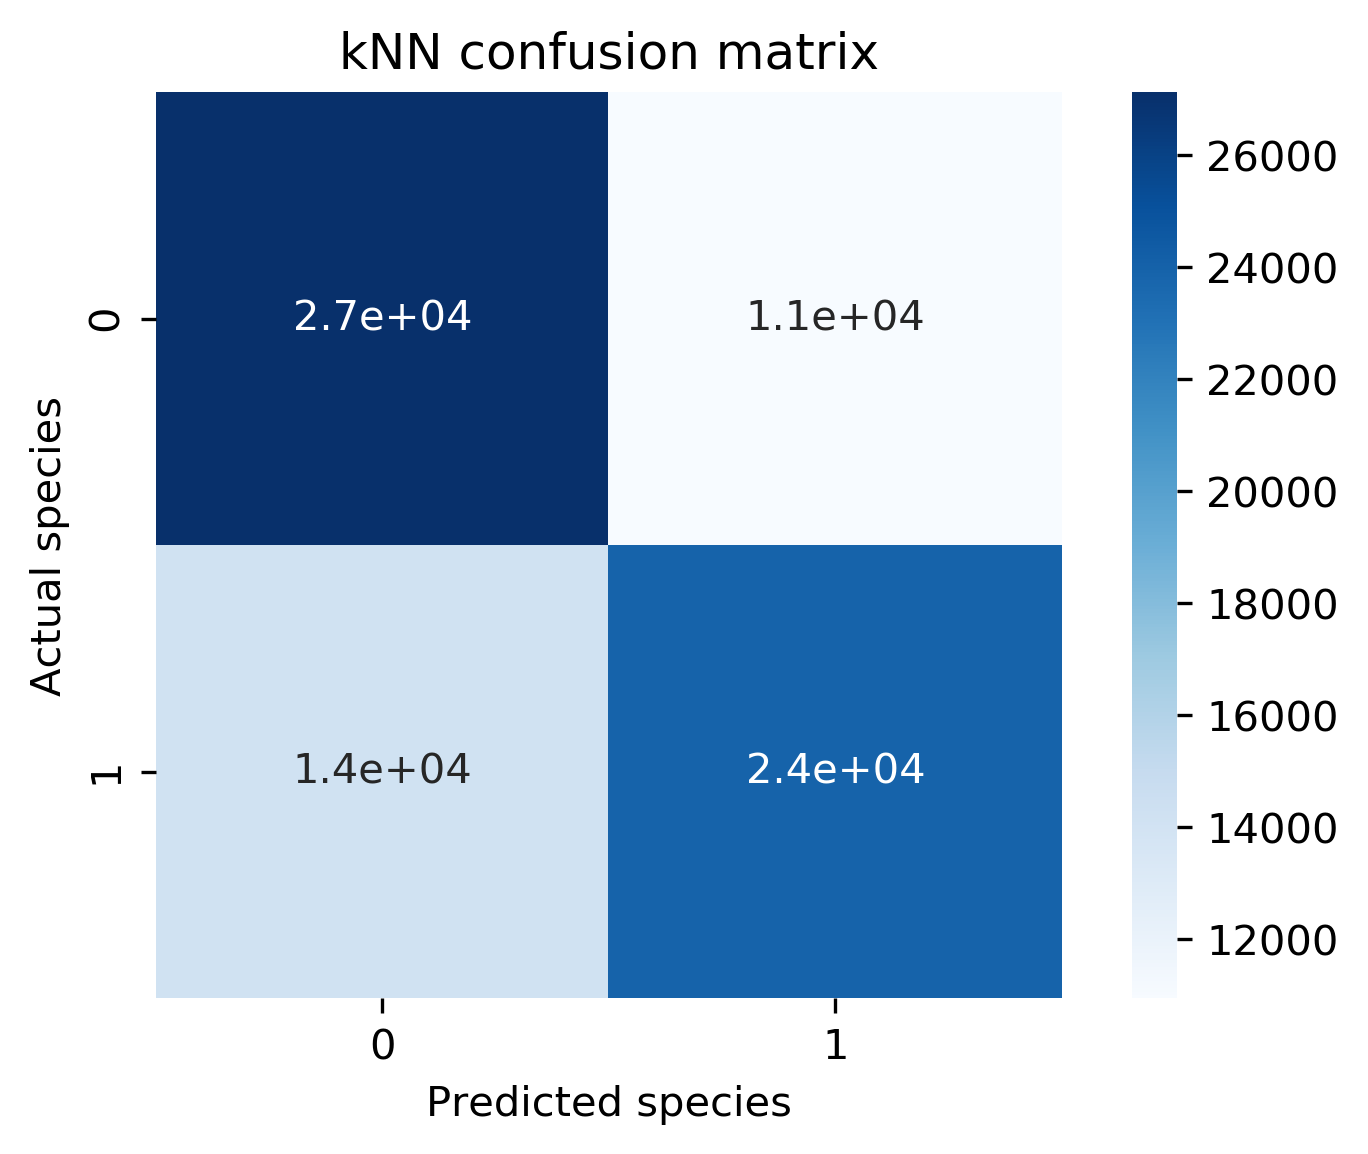

In [42]:
rf_cmatrix=confusion_matrix(y_cv_rd, rf_grid.predict(X_cv_rd))
plt.figure(dpi=150)
sns.heatmap(rf_cmatrix, cmap=plt.cm.Blues, annot=True, square=True)
            

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Random Forest matrix');